In [1]:
import cuqi
import numpy as np
from cuqi.sampler import MH
from cuqi.distribution import JointDistribution, Gaussian
import matplotlib.pyplot as plt

# imported our newly implemented DA class
from da import DA

# We will use solve_ivp to solve the ODE
from scipy.integrate import solve_ivp

# Set seed
np.random.seed(0)

In [2]:
print(cuqi.__version__)

0+untagged.2748.g0eb7d56


# 0. Problem description
The purpose of this notebook is to implement the Delayed acceptance (DA) MCMC method in CUQIpy and then demonstrate its usage in inferring parameters of a system of ordinary differential equations (ODEs). The ODE under interest is the [__Predictor-prey__ (Lotka-Volterra)](https://se.mathworks.com/help/matlab/math/numerical-integration-of-differential-equations.html) model and we would love to reconstruct the values of $(a,b)$ based on some measurement data.
$$        \begin{align*}
            \frac{d x}{d t} &= x - axy\\
            \frac{dy}{dt} &= -y + bxy
        \end{align*}$$
The measurement data ($x_{data}$, $y_{data}$) at a range of time points are corrupted by Gaussian noise:
$$        \begin{align*}
            x_{data} &= x + e\\
            y_{data} &= y + e
        \end{align*}$$
and $\mathbf{e}\sim\mathcal{N}(\mathbf{0},\sigma_e^2)$.

For the priors, we have
$$ \log a \sim\mathcal{N}(-4,0.3)\\
   \log b \sim\mathcal{N}(-4,0.3)$$

In the following sections, we will
1. have a brief review of the DA method;
2. prepare two levels of forward models;
3. generate noisy fake/measurement data;
4. conduct MCMC with `MH` and the newly implemented `DA` sampler.
<!-- ![problem_description.png](problem_description.png) -->

# 1. Method: Delayed acceptance (DA) MCMC

1. Initialize $\theta_0$.
2. For $n=0 \ to\ N-1$
  - Generate a proposal $\theta^\prime$ from distribution  $q(\theta^\prime|\theta_n)$.
  - Generate $u$ from uniform $\mathcal{U}_{[0,1]}$
  - Calculate acceptance ratio $\alpha = \min\left(1, \frac{\pi^*(\theta^\prime)q(\theta_n|\theta^\prime)}{\pi^*(\theta_n)q(\theta^\prime|\theta_n)}\right)$
  - If  $u < \alpha$
    - Calculate $\beta = \min\left(1, \frac{\pi(\theta^\prime)\pi^*(\theta_n)}{\pi(\theta_n)\pi^*(\theta^\prime)}\right)$
    - Generate $v$ from uniform $\mathcal{U}_{[0,1]}$
    - If $v<\beta$
      - $\theta_{n+1} = \theta^\prime$
    - else
      - $\theta_{n+1} = \theta_n$
  - else
      -  $\theta_{n+1} = \theta_n$

# 2. Prepare fine and coarse forward models

The full forward model solves the ode in time range [$0$, $T$] and calculate the likelihood with full measurement data, while the reduced model solve in time range [$0$, $T/2$], and evalute the likelihood with half of the measurement data.

In [3]:
# data set from matlab
true_x = [2, 2.5]
# We will use the log of the parameters to make sure they are positive
true_x = np.log(true_x)
y0 = [2, 2]
error_sigma = 0.1
T = 15

no_of_measurement = 50

def dydx(t, y, a, b):
    return np.array([y[0] - a*y[0]*y[1], -1*y[1] + b*y[0]*y[1]])

def predator_prey_reference(theta):
    datapoints = np.linspace(0,T,no_of_measurement)
    a, b = np.exp(theta)
    sol = solve_ivp(lambda t, y: dydx(t, y, a, b), [0, T], y0, dense_output=True, t_eval=datapoints) #, t_eval=[2, 4, 8, 10]
    return sol

def predator_prey(theta):
    datapoints = np.linspace(0,T,no_of_measurement)
    a, b = np.exp(theta)
    sol = solve_ivp(lambda t, y: dydx(t, y, a, b), [0, T], y0, dense_output=True, t_eval=datapoints) #, t_eval=[2, 4, 8, 10]
    if sol.success:
        return sol.y.flatten()
    else:
        print("solve_ivp failed")
my_model = cuqi.model.Model(predator_prey, range_geometry=no_of_measurement*2, domain_geometry=2) #range_geometry := output, domain_geometry := input

def predator_prey_reduced(theta):
    datapoints = np.linspace(0,T,no_of_measurement)[:int(no_of_measurement/2)]
    a, b = np.exp(theta)
    sol = solve_ivp(lambda t, y: dydx(t, y, a, b), [0, T/2], y0, dense_output=True, t_eval=datapoints) #, t_eval=[2, 4, 8, 10]
    if sol.success:
        return sol.y.flatten()
    else:
        print("solve_ivp failed")
my_reduced_model = cuqi.model.Model(predator_prey_reduced, range_geometry=no_of_measurement, domain_geometry=2) #range_geometry := output, domain_geometry := input

# 3. Prepare noisy data

We will prepare two set of measurement data, which will be used with the full forward model and the reduced forward model, respectively

In [4]:
sol_ref = predator_prey_reference(true_x)
true_y = my_model.forward(true_x)
true_reduced_y = my_reduced_model.forward(true_x)

In [5]:
noise = error_sigma*np.random.randn(no_of_measurement*2)
my_data = true_y +  noise
my_reduced_data = np.append(my_data[0:int(no_of_measurement/2)], my_data[no_of_measurement:no_of_measurement+int(no_of_measurement/2)])

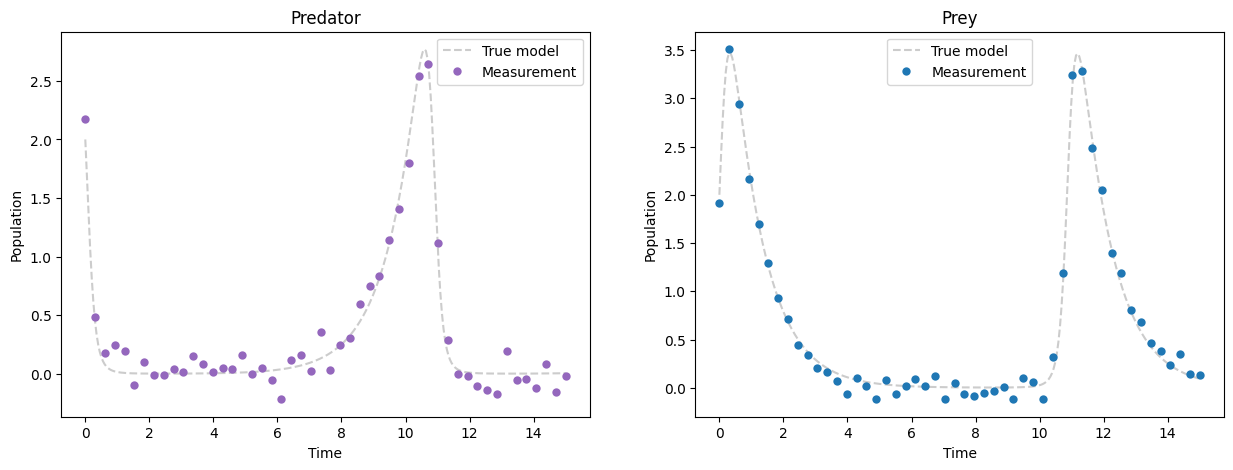

In [6]:
t = np.linspace(0, T, 300)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.plot(t, sol_ref.sol(t)[0], '--', color= (0.8, 0.8, 0.8))
plt.plot(np.linspace(0,T,no_of_measurement), my_data[:no_of_measurement], 'o', markerfacecolor="tab:purple", markeredgecolor='none')
plt.legend(["True model","Measurement"])
plt.legend(["True model","Measurement"])
plt.subplot(1,2,2)
plt.title("Prey")
plt.xlabel("Time")
plt.ylabel("Population")
plt.plot(t, sol_ref.sol(t)[1], '--', color= (0.8, 0.8, 0.8))
plt.plot(np.linspace(0,T,no_of_measurement), my_data[no_of_measurement:], 'o', markerfacecolor="tab:blue", markeredgecolor='none')
plt.legend(["True model","Measurement"])

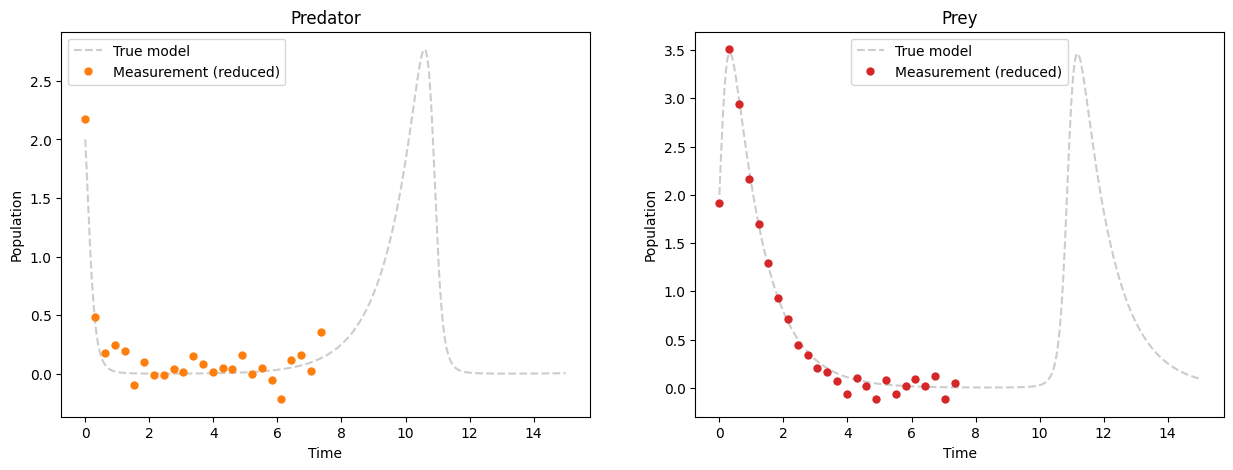

In [7]:
t = np.linspace(0, T, 300)
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Predator")
plt.xlabel("Time")
plt.ylabel("Population")
plt.plot(t, sol_ref.sol(t)[0], '--', color= (0.8, 0.8, 0.8))
plt.plot(np.linspace(0,T,no_of_measurement)[:int(no_of_measurement/2)], my_reduced_data[:int(no_of_measurement/2)], 'o', markerfacecolor="tab:orange", markeredgecolor='none')
plt.legend(["True model","Measurement (reduced)"])
plt.subplot(1,2,2)
plt.title("Prey")
plt.xlabel("Time")
plt.ylabel("Population")
plt.plot(t, sol_ref.sol(t)[1], '--', color= (0.8, 0.8, 0.8))
plt.plot(np.linspace(0,T,no_of_measurement)[:int(no_of_measurement/2)], my_reduced_data[int(no_of_measurement/2):], 'o', markerfacecolor="tab:red", markeredgecolor='none')
plt.legend(["True model","Measurement (reduced)"])

# 4. Set Prior

In [8]:
# Prior mean and variance
prior_mu = np.array([-4, -4])
prior_sigma = np.array([0.3, 0.3])
my_prior = cuqi.distribution.Gaussian(mean=prior_mu, cov=prior_sigma**2)

# 4. Set likelihood

We need to set two likelihoods, one for the full model and one for the reduced model. The likelihood for the reduced model is the same as the likelihood for the full model, but with the data reduced to half the size.

In [9]:
# Likelihood
my_likelihood = cuqi.distribution.Gaussian(mean=my_model(my_prior), cov=error_sigma**2)
my_reduced_likelihood = cuqi.distribution.Gaussian(mean=my_reduced_model(my_prior), cov=error_sigma**2)

# 4. Set Posterior

Now we are ready to define our `JointDistribution` with the above defined prior and likelihoods.

In [10]:
my_joint = JointDistribution(my_likelihood, my_prior)
my_posterior = my_joint(my_likelihood=my_data)

my_reduced_joint = JointDistribution(my_reduced_likelihood, my_prior)
my_reduced_posterior = my_reduced_joint(my_reduced_likelihood=my_reduced_data)

print(my_posterior)
print(my_reduced_posterior)

Posterior(
    Equation:
	 p(my_prior|my_likelihood) ∝ L(my_prior|my_likelihood)p(my_prior)
    Densities:
	my_likelihood ~ CUQI Gaussian Likelihood function. Parameters ['my_prior'].
 	my_prior ~ CUQI Gaussian.
 )
Posterior(
    Equation:
	 p(my_prior|my_reduced_likelihood) ∝ L(my_prior|my_reduced_likelihood)p(my_prior)
    Densities:
	my_reduced_likelihood ~ CUQI Gaussian Likelihood function. Parameters ['my_prior'].
 	my_prior ~ CUQI Gaussian.
 )


# 4. Draw samples from posterior

We use both `MH` and the newly implemented `DA` to draw samples from the posterior distribution. While `DA` will necessarily lower statistical efficiency due to the additional acceptance/rejection step, it improves the computational efficiency by reducing the number of runs of the full forward model.

Sample 10300 / 10300

Average acceptance rate: 0.2372 MCMC scale: 0.008366484429101402 



array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>]],
      dtype=object)

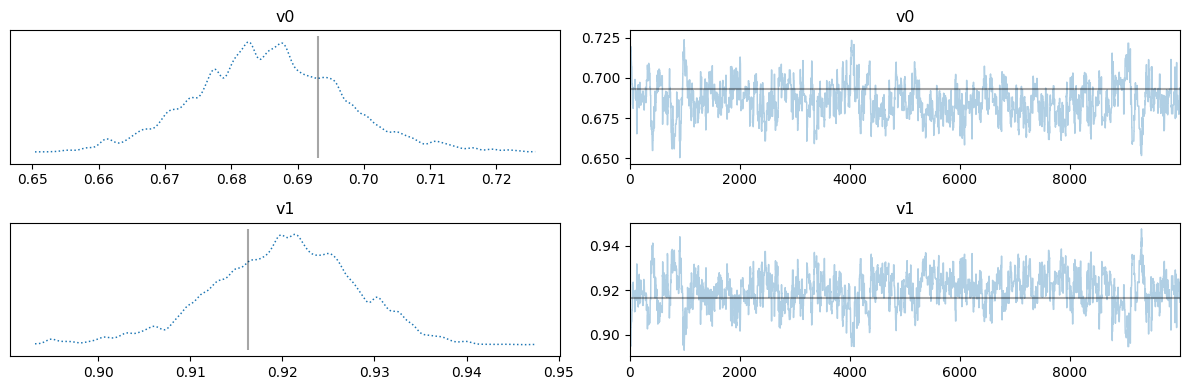

In [11]:
sampler = cuqi.sampler.MH(my_posterior, scale=0.008)
samples = sampler.sample_adapt(10000, Nb=300)
samples.plot_trace(exact=true_x)

Sample 10300 / 10300

Average acceptance rate: 0.2178 MCMC scale: 0.007415936723406018 



array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>]],
      dtype=object)

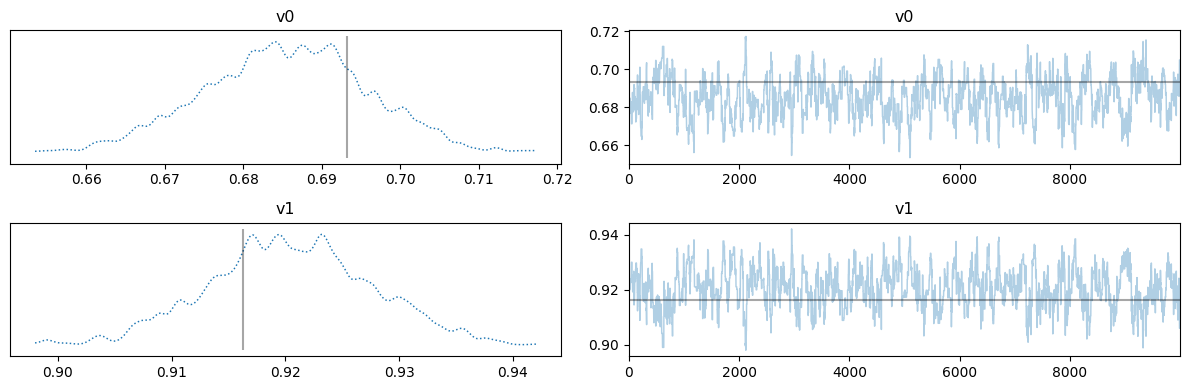

In [12]:
da_sampler = DA(my_posterior, my_reduced_posterior, scale=0.008)
da_samples = da_sampler.sample_adapt(10000, Nb=300)
da_samples.plot_trace(exact=true_x)